## ICEWS exploration 
(starting from David Masad's code)

See also : Philip Schrodt's newer data aggregation project (http://phoenixdata.org/)

In [1]:
import os, re, json, csv
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import datetime as dt
import pprint as pp

import collections, itertools
from collections import defaultdict
from  more_itertools import unique_everseen

%pylab inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

# Downloading the data

The data is available via the Harvard Dataverse, at http://thedata.harvard.edu/dvn/dv/icews. The two datasets I use are the [ICEWS Coded Event Data](http://thedata.harvard.edu/dvn/dv/icews/faces/study/StudyPage.xhtml?globalId=doi:10.7910/DVN/28075&studyListingIndex=3_0be68920e78feaec1cd50a208193) and the [Ground Truth Data Set](http://thedata.harvard.edu/dvn/dv/icews/faces/study/StudyPage.xhtml?globalId=doi:10.7910/DVN/28119&studyListingIndex=3_0be68920e78feaec1cd50a208193).

Assume that all the annual data files, as well as the one Ground Truth data file, are in the same directory.

# Loading the data

In [2]:
# Path to directory where the data is stored
DATA = "./Event+GroundTruth Data/"

For testing purposes, I start by loading a single year into a pandas DataFrame. The data files are tab-delimited, and have the column names as the first row.

In [3]:
one_year = pd.read_csv(DATA + "events.1995.20150313082510.tab", sep="\t")

In [4]:
one_year

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude
0,926685,1995-01-01,Extremist (Russia),"Radicals / Extremists / Fundamentalists,Dissident",Russian Federation,Praise or endorse,51,3.4,Boris Yeltsin,"Elite,Executive,Executive Office,Government",Russian Federation,28235806,5,The Toronto Star,Moscow,NaN,Moskva,Russian Federation,55.7522,37.61560
1,926687,1995-01-01,Government (Bosnia and Herzegovina),Government,Bosnia and Herzegovina,Express intent to cooperate,30,4.0,Citizen (Serbia),"General Population / Civilian / Social,Social",Serbia,28235807,1,The Toronto Star,NaN,NaN,Bosnia,Bosnia and Herzegovina,44.0000,18.00000
2,926686,1995-01-01,Citizen (Serbia),"General Population / Civilian / Social,Social",Serbia,Express intent to cooperate,30,4.0,Government (Bosnia and Herzegovina),Government,Bosnia and Herzegovina,28235807,1,The Toronto Star,NaN,NaN,Bosnia,Bosnia and Herzegovina,44.0000,18.00000
3,926688,1995-01-01,Canada,NaN,Canada,Praise or endorse,51,3.4,City Mayor (Canada),"Government,Local,Municipal",Canada,28235809,3,The Toronto Star,NaN,NaN,Ontario,Canada,49.2501,-84.49980
4,926689,1995-01-01,Lawyer/Attorney (Canada),"Legal,Social",Canada,"Arrest, detain, or charge with legal action",173,-5.0,Police (Canada),"Government,Police",Canada,28235964,1,The Toronto Star,Montreal,Montreal,Quebec,Canada,45.5088,-73.58780
5,926690,1995-01-01,Military (Russia),"Military,Government",Russian Federation,fight with small arms and light weapons,193,-10.0,Russia,NaN,Russian Federation,28235965,4,The Toronto Star,NaN,NaN,Chechenskaya Respublika,Russian Federation,43.2500,45.83330
6,926691,1995-01-01,Citizen (United Kingdom),"General Population / Civilian / Social,Social",United Kingdom,"Reject proposal to meet, discuss, or negotiate",125,-5.0,Police (United Kingdom),"Government,Police",United Kingdom,28235967,3,The Toronto Star,NaN,NaN,NaN,United Kingdom,51.5085,-0.12574
7,926692,1995-01-01,Government (Canada),Government,Canada,Reject,120,-4.0,Canadian Armed Forces,"Government,Military",Canada,28235970,1,The Toronto Star,Calgary,NaN,Alberta,Canada,51.0501,-114.08500
8,926693,1995-01-01,Citizen (Japan),"General Population / Civilian / Social,Social",Japan,Express intent to meet or negotiate,36,4.0,Japan,NaN,Japan,28236154,5,Agence France-Presse,Tokyo,NaN,Tokyo-to,Japan,35.6895,139.69200
9,926694,1995-01-01,Military Judge (Peru),"Government,Military",Peru,Deny responsibility,16,-5.0,Citizen (Peru),"General Population / Civilian / Social,Social",Peru,28236242,2,Agence France-Presse,Lima,NaN,Provincia de Lima,Peru,-12.0432,-77.02820


In [5]:
one_year.dtypes

Event ID             int64
Event Date          object
Source Name         object
Source Sectors      object
Source Country      object
Event Text          object
CAMEO Code           int64
Intensity          float64
Target Name         object
Target Sectors      object
Target Country      object
Story ID             int64
Sentence Number      int64
Publisher           object
City                object
District            object
Province            object
Country             object
Latitude           float64
Longitude          float64
dtype: object

### Loading all the data

Iterate over all the data files, read each into a DataFrame, and then concatenate them together.

Notice that the Event Date column is an object (meaning a string), so when we load in all of the data we should tell pandas to parse it automatically. I added the *parse_dates=[1]* argument to the **.read_csv(...)** method, telling pandas to parse the second column as a date.

In [6]:
all_data = []
for f in os.listdir(DATA): # Iterate over all files
    if f[-3:] != "tab":  # Skip non-tab files.
        continue
    df = pd.read_csv(DATA + f, sep='\t', parse_dates=[1])
    all_data.append(df)

data = pd.concat(all_data)

Some of the ICEWS column names have spaces in them, which means they can't be referenced using pandas's period notation. To fix this, I rename the columns to replace the spaces with underscores:

In [7]:
cols = {col: col.replace(" ", "_") for col in data.columns}
#print cols
data.rename(columns=cols, inplace=True)

data.dtypes

Event_ID                    int64
Event_Date         datetime64[ns]
Source_Name                object
Source_Sectors             object
Source_Country             object
Event_Text                 object
CAMEO_Code                  int64
Intensity                 float64
Target_Name                object
Target_Sectors             object
Target_Country             object
Story_ID                    int64
Sentence_Number             int64
Publisher                  object
City                       object
District                   object
Province                   object
Country                    object
Latitude                  float64
Longitude                 float64
dtype: object

In [8]:
print(data.Event_Date.min())
print(data.Event_Date.max())

1995-01-01 00:00:00
2014-11-30 00:00:00


In [9]:
len(data)

14200680

Looks good! The data types are what we expect, and the dates seem to have been parsed correctly.

# Examining the data

A good initial examination of the data is seeing who the most frequent actors are. The following code counts how often each actor appears as the source or target of an event:

In [10]:
data.Source_Name.value_counts()

United States                                            345161
Russia                                                   204592
China                                                    201417
Police (India)                                           130586
Israel                                                   122383
Vladimir Putin                                           108780
Japan                                                    107619
India                                                    102736
George W. Bush                                           100812
United Nations                                            95535
European Union                                            95485
Iran                                                      89868
Citizen (India)                                           72614
South Korea                                               72172
United Kingdom                                            68151
North Korea                             

In [11]:
actors_source = data.Source_Name.value_counts()
actors_target = data.Target_Name.value_counts()
actor_counts = pd.DataFrame({"SourceFreq": actors_source,
                             "TargetFreq": actors_target})
actor_counts.fillna(0, inplace=True)
actor_counts["Total"] = actor_counts.SourceFreq + actor_counts.TargetFreq


Examine top 50 actors:

In [12]:
actor_counts.sort("Total", ascending=False, inplace=True)
actor_counts.head(50)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,SourceFreq,TargetFreq,Total
United States,345161.0,353935.0,699096.0
Russia,204592.0,277075.0,481667.0
China,201417.0,265519.0,466936.0
Israel,122383.0,157200.0,279583.0
Japan,107619.0,151082.0,258701.0
India,102736.0,155474.0,258210.0
Iran,89868.0,160362.0,250230.0
Citizen (India),72614.0,151347.0,223961.0
Unspecified Actor,0.0,210840.0,210840.0
United Nations,95535.0,110922.0,206457.0


What stood out to me was the mix of country-level actors with named individuals. Unlike event datasets that use CAMEO coding, leaders or sub-state organizations don't seem to be coded as add-ons to a state actor code (e.g. USAGOV) but separate actors in their own right.

**Update (03/29/2015):** The *_Sectors* column contains the role information that would otherwise be contained in the chained CAMEO designations. For example, if you scroll back to the first row of 1995 data, the target name is Boris Yeltsin, and the target sectors associated with him are "Elite,Executive,Executive Office,Government". 

The **Citizen (*Country*)** actor stood out to me in particular, especially since it isn't mentioned specifically in the included documentation -- so let's take a look at some of the rows that use it:

In [13]:
data[data.Source_Name=="Citizen (India)"].head()

,Event_ID,Event_Date,Source_Name,Source_Sectors,Source_Country,Event_Text,CAMEO_Code,Intensity,Target_Name,Target_Sectors,Target_Country,Story_ID,Sentence_Number,Publisher,City,District,Province,Country,Latitude,Longitude
676,927826,1995-01-11,Citizen (India),"General Population / Civilian / Social,Social",India,"Reject proposal to meet, discuss, or negotiate",125,-5.0,Narasimha Rao,"Executive Office,Executive,Government",India,28239021,2,The Associated Press Political Service,NaN,NaN,State of Tamil Nadu,India,11.0000,78.0000
783,927996,1995-01-12,Citizen (India),"General Population / Civilian / Social,Social",India,Express intent to meet or negotiate,36,4.0,United States,NaN,United States,28239081,1,The Associated Press Political Service,Swanton,Saline County,Nebraska,United States,40.3781,-97.0728
2151,2547954,1995-01-26,Citizen (India),"Social,General Population / Civilian / Social",India,Demonstrate or rally,141,-6.5,Unspecified Actor,Unspecified,NaN,28242253,2,Reuters News,Jammu,NaN,State of Jammu and Kashmir,India,32.7357,74.8691
5760,935070,1995-03-06,Citizen (India),"Social,General Population / Civilian / Social",India,Kill by physical assault,1823,-10.0,Congress Party,"(National) Major Party,Government Major Party ...",India,28915932,4,The Associated Press Political Service,Hyderabad,Hyderabad,State of Andhra Pradesh,India,17.3841,78.4564
5766,935081,1995-03-06,Citizen (India),"Social,General Population / Civilian / Social",India,Use unconventional violence,180,-9.0,Militant (India),Unidentified Forces,India,28915955,6,The Associated Press Political Service,New Delhi,NaN,National Capital Territory of Delhi,India,28.6358,77.2244


So it looks like Citizen really means civilians, or possibly civil society actors unaffiliated with any organization the ICEWS coding system recognizes.

**Update (03/29/2015):** I had trouble finding news events that corresponded to the events above, but Jennifer Lautenschlager pointed me to [this news article](http://articles.latimes.com/1995-03-12/news/mn-41961_1_violence-elections-india) that indicates that there was election violence in India in that time frame.

To get country-level actors comparable to other event datasets, looks like we need to use the source and target country columns:

In [14]:
country_source = data.Source_Country.value_counts()
country_target = data.Target_Country.value_counts()
country_counts = pd.DataFrame({"SourceFreq": country_source,
                             "TargetFreq": country_target})
country_counts.fillna(0, inplace=True)
country_counts["Total"] = country_counts.SourceFreq + country_counts.TargetFreq

In [15]:
country_counts.sort("Total", ascending=False, inplace=True)
country_counts.head(10)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,SourceFreq,TargetFreq,Total
United States,1040844.0,835165,1876009.0
India,847385.0,832066,1679451.0
Russian Federation,777789.0,739832,1517621.0
China,567625.0,550743,1118368.0
Japan,357171.0,344791,701962.0
Australia,357802.0,336884,694686.0
Israel,351765.0,327365,679130.0
United Kingdom,346278.0,316152,662430.0
Iran,309100.0,302644,611744.0
Occupied Palestinian Territory,260803.0,331519,592322.0


This looks pretty good too! India seems more represented compared to what I've seen in other datasets, and of course Israel/Palestine maintain their usual place on the event data leaderboard.

**Update (03/29/2015):** Since the Sectors are also an important way of understanding the relevant data, let's get their frequencies too. Sectors are a bit trickier, since each cell can contain multiple selectors, separated by commas. So we need to loop over each cell, split the selectors mentioned, and count each one.

In [16]:
# Count source sectors
source_sectors = defaultdict(int)
source_sector_counts = data.Source_Sectors.value_counts()
for sectors, count in source_sector_counts.iteritems():
    sectors = sectors.split(",")
    for sector in sectors:
        source_sectors[sector] += 1

# Count Target sectors
target_sectors = defaultdict(int)
target_sector_counts = data.Target_Sectors.value_counts()
for sectors, count in target_sector_counts.iteritems():
    sectors = sectors.split(",")
    for sector in sectors:
        target_sectors[sector] += 1
        
# Convert into series
source_sectors = pd.Series(source_sectors)
target_sectors = pd.Series(target_sectors)
# Combine into a dataframe, and fill missing with 0
sector_counts = pd.DataFrame({"SourceFreq": source_sectors,
                              "TargetFreq": target_sectors})

sector_counts.fillna(0, inplace=True)
sector_counts["Total"] = sector_counts.SourceFreq + sector_counts.TargetFreq

In [17]:
sector_counts.sort("Total", ascending=False, inplace=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [18]:
sector_counts.head(10)

,SourceFreq,TargetFreq,Total
Government,177121.0,139011.0,316132.0
Parties,171477.0,135615.0,307092.0
Ideological,153803.0,122046.0,275849.0
(National) Major Party,134063.0,106326.0,240389.0
Executive,129382.0,103347.0,232729.0
Elite,92550.0,79882.0,172432.0
Legislative / Parliamentary,63828.0,45897.0,109725.0
Executive Office,54361.0,49471.0,103832.0
Cabinet,57398.0,42207.0,99605.0
Center Left,48735.0,37661.0,86396.0


In [19]:
sector_counts.tail(10)

,SourceFreq,TargetFreq,Total
Western,1.0,1.0,2.0
Nepali-Pahari,1.0,1.0,2.0
Bedouin,2.0,0.0,2.0
Navy Headquarters,1.0,1.0,2.0
Unspecified,0.0,1.0,1.0
Army Education / Training,0.0,1.0,1.0
Consumer Services MNCs,1.0,0.0,1.0
Saharan,1.0,0.0,1.0
State-Owned Consumer Goods,1.0,0.0,1.0
State-Owned Durable Goods,1.0,0.0,1.0


In addition to CAMEO-type actor designations (e.g. Government) it looks like some of the Sectors also resemble the Issues in Phoenix, or Themes in the GDELT GKG.

## Daily Event Counts

An easy way to get an idea of whether there were significant changes in data collection over time is to look at total events over time. ICEWS events have the full daily date only, so let's go with that and look at daily events.

In [20]:
daily_events = data.groupby("Event_Date").aggregate(len)["Event_ID"]

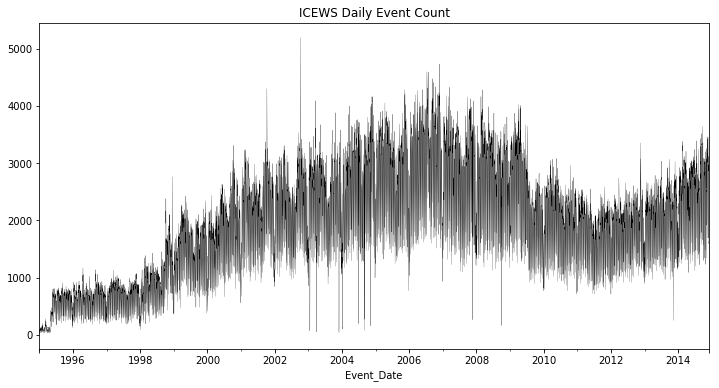

In [21]:
daily_events.plot(color='k', lw=0.2, figsize=(12,6), 
                  title="ICEWS Daily Event Count")

There seems to be a definite ramp-up period from 1995 through 1999 or so, and some sort of fall in event volume around 2009. Notice that there are also a few individual days, especially around 2004, with very few events for some reason.

**Update (03/29/2015):** Jennifer Lautenschlager clarified that the jumps in the 1995-2001 period reflect publishers entering incrementally into the commercial data system that feeds into ICEWS. The post-2008 dip reflects a decline in number of stories overall, possibly driven by budget cuts due to the recession.

Since each event has an associated Story ID, we can count how many unique stories are processed by ICEWS every day and end up generating events.

In [22]:
daily_stories = data.groupby("Event_Date").aggregate(pd.Series.nunique)["Story_ID"]

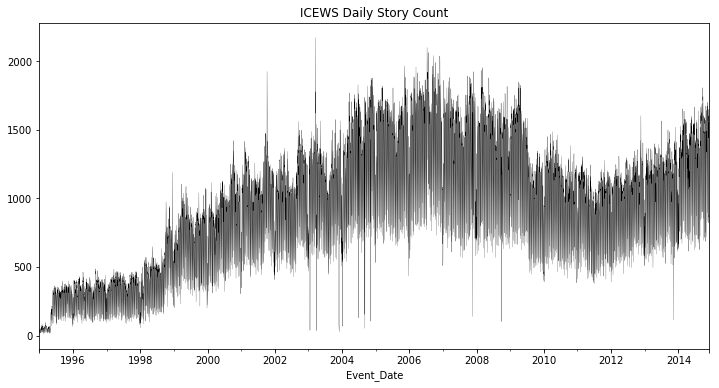

In [23]:
daily_stories.plot(color='k', lw=0.2, figsize=(12,6), 
                   title="ICEWS Daily Story Count")

With these two series, we can measure the daily average events generated per story:

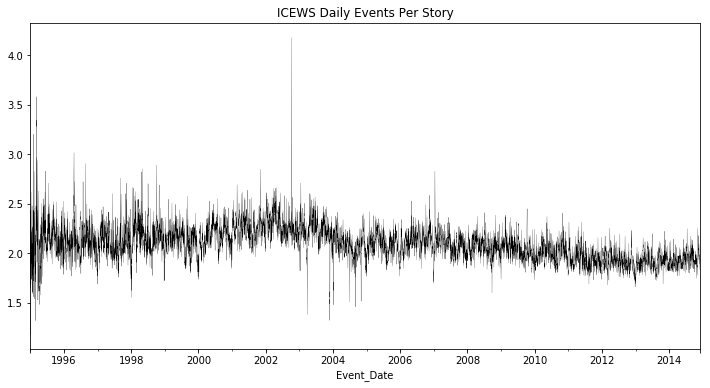

In [24]:
events_per_story = daily_events / daily_stories
events_per_story.plot(color='k', lw=0.2, figsize=(12,6), 
                      title="ICEWS Daily Events Per Story")

This confirms that indeed, except for a few anomalies, the number of events generated per story stays relatively consistent over time. Nevertheless, it's probably important to at least try to distinguish between fewer stories as caused by fewer newsworthy events, and fewer stories as caused by fewer journalists writing them.

## Mapping

Another good way to get an idea of the dataset's coverage is to put the events on a map. To do that, let's group the data by the latitude and longitude for each event, and count the number of events at each point. Then we can put those points on a world map using the basemap package.

In [25]:
points = data.groupby(["Latitude", "Longitude"]).aggregate(len)["Event_ID"]
points = points.reset_index()

Nobody will be surprised that the distribution of events-per-point is very long-tailed, with many points having only a small number of events, and a small number of points having hundreds of thousands of events. 

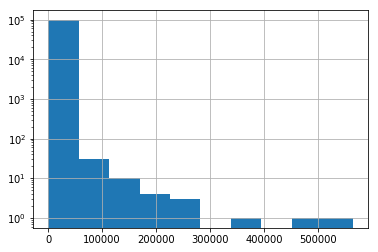

In [26]:
points.Event_ID.hist()
plt.yscale('log')

So the best way to deal with this is to plot point size based on the log of the number of events recorded there.


A few regions -- particularly the Indian subcontinent, East Asia and South America -- seem much better covered than in some other datasets. US Pacific Command was one of ICEWS's first customers, so it makes sense that its AOR would be well covered. Nigeria also seems to be relatively densly-covered, though whether this is because of particular attention or simply its population and regional significance isn't clear.

The ICEWS documentation says that purely domestic US events aren't included. This explains why the continental US appears sparser than some other datasets -- but there are obviously many points still left. Most of these events have at least one foreign actor, and apparently very few purely domestic events slip past the filters ICEWS have in place.

## The Israeli-Palestinian Dyad

Back to everyone's favorite dyad, which has had more than its fair share of event data analysis pointed at it. Let's subset all events originating from Israel and targeting what ICEWS codes as the Occupied Palestinian Territory, and vice-versa.

In [29]:
dyad = ["Israel", "Occupied Palestinian Territory"]
ilpalcon = data[(data.Source_Country.isin(dyad)) & 
                (data.Target_Country.isin(dyad))]

In [31]:
ilpalcon.head()

,Event_ID,Event_Date,Source_Name,Source_Sectors,Source_Country,Event_Text,CAMEO_Code,Intensity,Target_Name,Target_Sectors,Target_Country,Story_ID,Sentence_Number,Publisher,City,District,Province,Country,Latitude,Longitude
50,926771,1995-01-03,"Citizen (Palestinian Territory, Occupied)","Social,General Population / Civilian / Social",Occupied Palestinian Territory,Criticize or denounce,111,-2.0,Yitzhak Rabin,"Government,State-Owned Defense / Security,Exec...",Israel,28235898,4,The Toronto Star,Bethlehem,NaN,West Bank,Occupied Palestinian Territory,31.7049,35.2038
132,926876,1995-01-03,Yitzhak Rabin,"Government,State-Owned Defense / Security,Exec...",Israel,Make statement,10,0.0,Government (Israel),Government,Israel,28242652,3,The Wall Street Journal Europe,Jerusalem,NaN,Jerusalem District,Israel,31.7690,35.2163
133,926877,1995-01-03,Cabinet / Council of Ministers / Advisors (Isr...,"Government,Cabinet,Executive",Israel,Praise or endorse,51,3.4,Yitzhak Rabin,"Government,State-Owned Defense / Security,Exec...",Israel,28242652,4,The Wall Street Journal Europe,Jerusalem,NaN,Jerusalem District,Israel,31.7690,35.2163
161,926955,1995-01-04,Yasir Arafat,"Executive Office,Government,Executive",Occupied Palestinian Territory,Engage in diplomatic cooperation,50,3.5,Israel,NaN,Israel,28241261,3,The Christian Science Monitor,Gaza,NaN,Gaza Strip,Occupied Palestinian Territory,31.5000,34.4667
162,926956,1995-01-04,Yasir Arafat,"Executive Office,Government,Executive",Occupied Palestinian Territory,Engage in diplomatic cooperation,50,3.5,Hamas,"Parties,(National) Major Party,Dissident,Nongo...",Occupied Palestinian Territory,28241261,3,The Christian Science Monitor,Gaza,NaN,Gaza Strip,Occupied Palestinian Territory,31.5000,34.4667


Unlike GDELT and Phoenix, ICEWS doesn't include a quad/penta-code categorizing events into broadly cooperative or conflict actions (though you can create them yourself using the ICEWS CAMEO code, e.g. as described in the [Phoenix documentation](https://s3.amazonaws.com/oeda/docs/phoenix_codebook.pdf)). Instead, it provides an **Intensity** score -- positive intensity indicates positive events (providing assistance, etc.) while negative scores indicate conflict (criticism, physical attacks). Taking the average intensity for some period of time should provide a rough estimate of each side's posture towards the other.

Let's break down the subset further, one for Israeli-initiated actions and one for Palestinian-initiated ones. That will give us a rough estimate of reciprocity -- is one side behaving more peacefully towards the other, or are their actions relatively mirrored?

First, we select Israel-initiated events, and get the mean intensity by day.

In [32]:
il_initiated = ilpalcon[ilpalcon.Source_Country=="Israel"]
il_initiated = il_initiated.groupby("Event_Date")
il_initiated = il_initiated.aggregate(np.mean)["Intensity"]

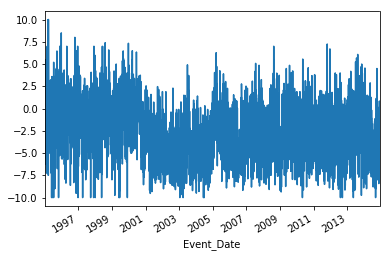

In [33]:
il_initiated.plot()

It looks like daily events are too noisy to give us a good picture of what's going on. To let's use pandas's rolling mean tool to see the average intensity across a 30-day window:

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  if __name__ == '__main__':


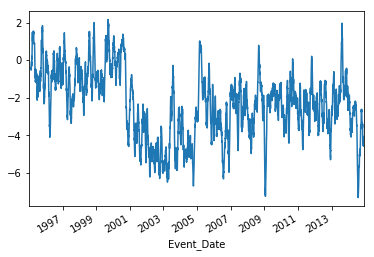

In [34]:
pd.rolling_mean(il_initiated, 30).plot()

Notice the sharp drop that occurs in late 2000, marking the beginning of the Second Intifada.

Now let's get the same dataset for Palestinian-initiated actions. This time, I string together the pandas operations using the '\' operator, which allows multiple lines to be strung together for legibility as if they were a single line of code:

In [35]:
pal_initiated = ilpalcon[ilpalcon.Source_Country=="Occupied Palestinian Territory"] \
                        .groupby("Event_Date") \
                        .aggregate(np.mean) \
                        ["Intensity"]

Next, combining the two mean intensity series into a single dataframe:

In [36]:
df = pd.DataFrame({"IL_Initiated": pd.rolling_mean(il_initiated, 30),
                   "PAL_Initiated": pd.rolling_mean(pal_initiated, 30)})

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  from ipykernel import kernelapp as app


And now we can plot the mean intensity of actions initiated by each side.

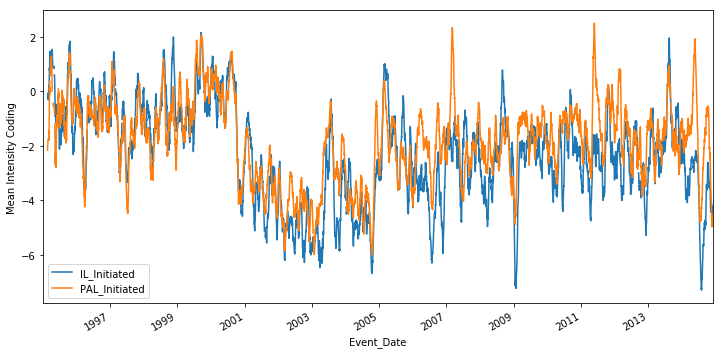

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
df.plot(ax=ax)
ax.set_ylabel("Mean Intensity Coding")

Not too surprisingly, they seem to overlap almost perfectly. There are a few points that stand out where the lines diverge significantly -- in a more in-depth analysis, they might warrant further examination to see whether they represent something interesting happening on the ground, or just a blip in the data collection.

We can correlate the series, and see that they do indeed track each other pretty closely (though not as perfectly as they may look on visual examination):

In [38]:
df.corr()

,IL_Initiated,PAL_Initiated
IL_Initiated,1.000000,0.785333
PAL_Initiated,0.785333,1.000000


# Ground Truth Dataset

One of ICEWS's biggest advantages is that it includes not only machine-coded event data, but hand-validated ground truth data on whether, on a monthly basis, each country is experiencing one of several types of conflict events. 

Let's load it and take a look:

In [39]:
ground_truth = pd.read_csv(DATA + "gtds_2001.to.may.2014.csv")

In [40]:
ground_truth.head()

,ccode,country,year,month,time,ins,reb,dpc,erv,ic,notes,coder,insnotes,dpcnotes,rebnotes,ervnotes,icnotes
0,20,Canada,2001,1,2001m1,0,0,0,0,0,NaN,Bentley & Leonard,NaN,NaN,NaN,NaN,NaN
1,20,Canada,2001,2,2001m2,0,0,0,0,0,NaN,Bentley & Leonard,NaN,NaN,NaN,NaN,NaN
2,20,Canada,2001,3,2001m3,0,0,0,0,0,NaN,Bentley & Leonard,NaN,NaN,NaN,NaN,NaN
3,20,Canada,2001,4,2001m4,0,0,0,0,0,NaN,Bentley & Leonard,NaN,NaN,NaN,NaN,NaN
4,20,Canada,2001,5,2001m5,0,0,0,0,0,NaN,Bentley & Leonard,NaN,NaN,NaN,NaN,NaN


The columns **ins** to **ic** are 1 if the country experienced that event during that month, and 0 otherwise. They are:

* **ins:** Insurgency
* **reb:** Rebellion
* **dpc:** Domestic political crisis
* **erv:** Ethnic or religious violence
* **ic:** International conflict

For more details, see the GTDS documentation.

In [41]:
# Convert the 'time' column to datetime:
ground_truth["time"] = pd.to_datetime(ground_truth.time, format="%Ym%m")

We can do some simple analysis on the ground truth dataset alone, for example see how many insurgencies are going on in the world on a month-by-month basis:

In [42]:
insurgency_count = ground_truth.groupby("time").aggregate(sum)["ins"]

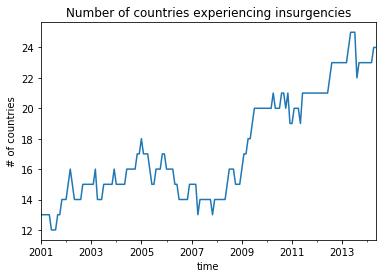

In [43]:
insurgency_count.plot()
plt.ylabel("# of countries")
plt.title("Number of countries experiencing insurgencies")

## Combining the event data with ground truth

The real advantage that the ground truth data gives us is being able to combine it with the machine-coded event data for analysis and ultimately prediction. 

In this example, I'm going to do a very simple analysis, and try and see whether countries experiencing one of the conflicts measured by the GTDS generate more events, and events of lower intensity.

First, we count how many 'bad things' are happening per country-month:

In [44]:
ground_truth["Conflict"] = 0
for col in ["ins", "reb", "dpc", "erv", "ic"]:
    ground_truth.Conflict += ground_truth[col]

All we care about for now is the country, the month, and the count of conflict types:

In [45]:
monthly_conflict = ground_truth[["time", "country", "Conflict"]]

In [46]:
monthly_conflict.head()

,time,country,Conflict
0,2001-01-01,Canada,0
1,2001-02-01,Canada,0
2,2001-03-01,Canada,0
3,2001-04-01,Canada,0
4,2001-05-01,Canada,0


Now let's go back to the ICEWS event data, and aggregate it on a country-month basis too. For purposes of this analysis, I'll associate events with the country that ICEWS places them in, rather than the source or target country.

I'll collect two measures: how many events were generated per country-month, and what their average intensity was.

ICEWS events are on a daily basis, so we need to associate a year-month with each event. Unfortunately, pandas doesn't know how to deal with 'months' -- notice that we converted the ground truth event date into the first day of the relevant month. We'll do the same for the ICEWS events:

In [ ]:
get_month = lambda x: pd.datetime(x.year, x.month, 1)
data["YearMonth"] = data.Event_Date.apply(get_month)

Now we'll group the data by country and month (really, first-day-of-the-month) and get the number and mean intensity of events for each.

In [ ]:
monthly_grouped = data.groupby(["YearMonth", "Country"])
monthly_counts = monthly_grouped.aggregate(len)["Event_ID"]
monthly_intensity = monthly_grouped.aggregate(np.mean)["Intensity"]

And combine these series into a single DataFrame:

In [ ]:
monthly_events = pd.DataFrame({"EventCounts": monthly_counts,
                               "MeanIntensity": monthly_intensity})
monthly_events.reset_index(inplace=True)

In [ ]:
monthly_events.head()

So this is fun: country names in the ICEWS event dataset are written with only the first letters capitalized, but the GTDS country names are in ALL CAPS. We need to convert one to the other in order to be able to match them -- and making country names all-caps is easier than dealing with title-casing multi-word all-cap country names.

In [ ]:
capitalize = lambda x: x.upper()
monthly_events["Country"] = monthly_events.Country.apply(capitalize)

Now that we've done that, we can merge the dataframes on month and country name. The merge includes all the columns from both dataframes by default, so we need to only keep the ones we're interested in:

In [ ]:
monthly_data = monthly_conflict.merge(monthly_events,
                       left_on=["time","country"], right_on=["YearMonth", "Country"])
monthly_data = monthly_data[["YearMonth", "Country", "Conflict", "EventCounts", "MeanIntensity"]]

In [ ]:
monthly_data.head()

Now let's make some quick box plots and eyeball whether conflicts make a difference for data generation:

In [ ]:
monthly_data.boxplot(column="EventCounts", by="Conflict")

In [ ]:
monthly_data.boxplot(column="MeanIntensity", by="Conflict")

We see a similar thing here -- no- or low-conflict country-months generate a wide variety of mean intensities, but the median mean intesity seems to become more negative with higher conflict scores.

However, what's the deal with the data points showing a very low mean intensity (which indicates conflict) when the ground-truth doesn't indicate that there were conflicts occuring? Let's check:

In [ ]:
monthly_data[(monthly_data.Conflict==0) & (monthly_data.MeanIntensity<-9)]

Ah -- it looks like all of these were very low event counts. Remember that these are monthly, and one or two intensly-negative events generated in an entire month probably are not themselves strong indicators of conflict. At the very least, so few events probably also indicate that there isn't much collection of events happening for that country in general.